In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Effect of sampling parameters on runrtime

Text(0.5, 0, 'Optimality and flux_traction combinations')

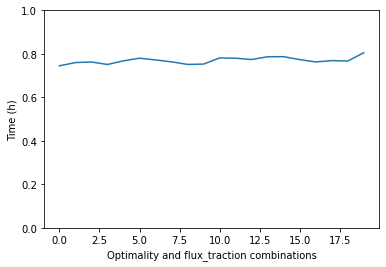

In [2]:
# Sampling parameters
sp = pd.read_csv('runtimes_colea.csv')
plt.plot(np.arange(0, len(sp)), sp['runtime']/3600)
plt.ylim([0, 1])
plt.ylabel('Time (h)')
plt.xlabel('Optimality and flux_traction combinations')

In [3]:
print(sp['runtime'].mean()/60)
print(sp['runtime'].std()/60)

46.201045048435525
0.8752820562817601


### Effect of filtering parameters on run time

In [4]:
sp = pd.read_csv('runtimes_filtering_colea_simplified.csv')

Text(0.5, 0, 'Optimality and flux_traction combinations')

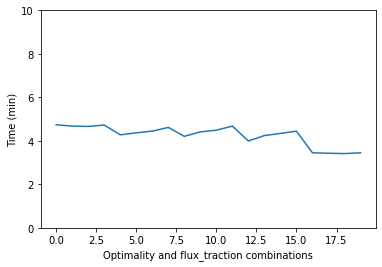

In [5]:
# Effect on run time
plt.plot(np.arange(0, len(sp)), sp['runtime']/60)
plt.ylim([0, 10])
plt.ylabel('Time (min)')
plt.xlabel('Optimality and flux_traction combinations')

### Effect of sampling parameters on target selection

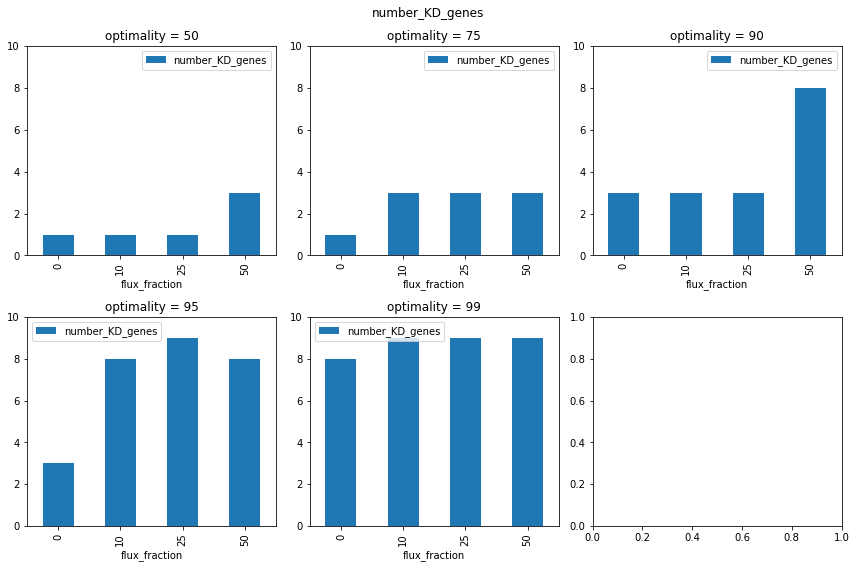

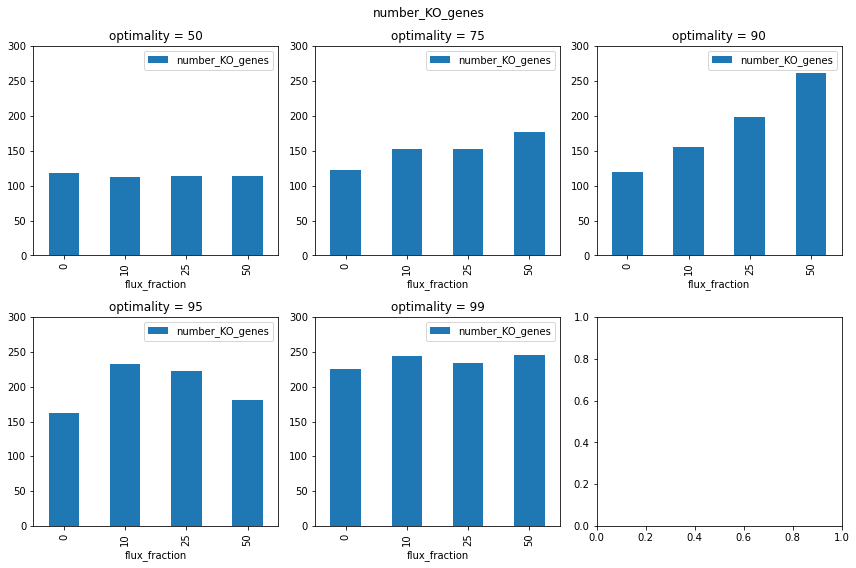

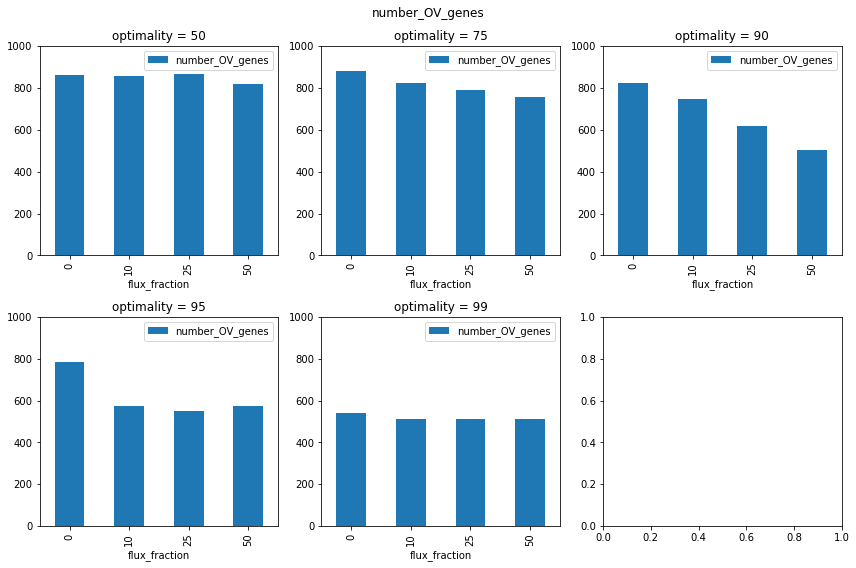

In [6]:
# Effect on number of targets (without any filtering)
for intervention, y_lim in zip(["number_KD_genes", "number_KO_genes", "number_OV_genes"], [10,300,1000]):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
    fig.suptitle(intervention)
    for opt, ax in zip([50, 75, 90, 95, 99], axs.flat):
        subset = sp[sp['optimality']==opt]
        subset.plot(x='flux_fraction', y=intervention, kind="bar", ax=ax)
        ax.set_title(f'optimality = {opt}')
        ax.set_ylim([0, y_lim])

### Effect of  filtering parameters on target selection

Used: 
- Optimality = 90
- Flux fraction = 1.25

In [7]:
# Reactions
r = pd.read_excel('colea_sampling_results_opt90_ff25.xlsx', sheet_name='reactions - all')

In [8]:
# Have a look at the conditions
r[['condition_1', 'condition_2', 'condition_3']].head()

condition_1           condition_2 condition_3
0  growing (pFBA)  growing (pFBA, slow)   producing
1  growing (pFBA)  growing (pFBA, slow)   producing
2  growing (pFBA)  growing (pFBA, slow)   producing
3  growing (pFBA)  growing (pFBA, slow)   producing
4  growing (pFBA)  growing (pFBA, slow)   producing

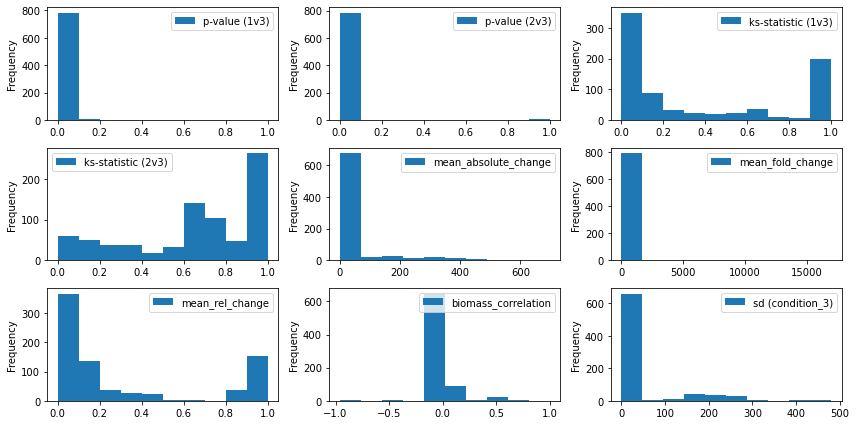

In [9]:
# Check distributions of parameter values
filtering_parameters = [
    'p-value (1v3)', # p-value growth and production scenarios
    'p-value (2v3)', # p-value slow growth and production scenarios
    'ks-statistic (1v3)', # overlap growth and production scenarios
    'ks-statistic (2v3)', # overlap slow growth and production scenarios
    'mean_absolute_change', # absolue flux change between growrh and production scenarios
    'mean_fold_change', # fold flux change between growrh and production scenarios
    'mean_rel_change', # flux relative change between growrh and production scenarios
    'biomass_correlation', # additional to ks (2v3)
    'sd (condition_3)' # std of flux distribution in production scenario
]

fig, axs = plt.subplots(3, 3, figsize=(12,6), tight_layout=True)
for parameter, ax in zip(filtering_parameters, axs.flat):
    r.plot(x='reaction', y=parameter, kind="hist", ax=ax)


In [10]:
# Check the number of targets
def get_number_targets(df, ks2_list, ks3_list, abs_change_list, std3_list, target):
    kd = []
    ko = []
    kd_ko = []
    ov = []
    for ks2 in ks2_list:
        for ks3 in ks3_list:
            for abs_change in abs_change_list:
                    for std_p in std3_list:
                        subset = df[
                            (df['ks-statistic (1v3)']>=ks2) &
                            (df['ks-statistic (2v3)']>=ks3) &
                            (df['mean_absolute_change']>=abs_change) &
                            (df['sd (condition_3)']<=std_p)
                        ]
                        kd_ko.append(
                            len(subset[subset['intervention']=='knock-down'])
                            + len(subset[subset['intervention']=='knock-out'])
                        )
                        kd.append(len(subset[subset['intervention']=='knock-down']))
                        ko.append(len(subset[subset['intervention']=='knock-out']))
                        ov.append(len(subset[subset['intervention']=='over-expression']))
    if target == 'ov':
        return ov
    elif target == 'kd':
        return kd
    elif target == 'ko':
        return ko
    elif target == 'kd_ko':
        return kd_ko

In [ ]:
# Bar plots

fig, axs = plt.subplots(2, 6, figsize = (24, 8), tight_layout=True)

params = ['optimality', 'flux_fraction', 'ks-statistic (1v3)', 'ks-statistic (2v3)', 'mean_absolute_change', 'sd (condition_3)']
param_names = ['Optimality', 'Flux Fraction', 'Ks (growth vs. production)', 'ks (slow growth vs. production)', 'Absolute Flux Change', 'Std Production']

for i, ax in zip(np.arange(len(axs.flat)), axs.flat):
    if i == 0:
        param_list = [50, 75, 90, 95, 99] 
        targets = []
        for param in param_list:
            targets.append(sp[(sp['optimality']==param) & (sp['flux_fraction']==25)]['number_OV_reactions'].iloc[0])
    elif i == 1:
        param_list = [0, 10, 25, 50] 
        targets = []
        for param in param_list:
            targets.append(sp[(sp['optimality']==90) & (sp['flux_fraction']==param)]['number_OV_reactions'].iloc[0]) 
        param_list = [1, 1.10, 1.25, 1.50] 
    elif i==2:
        param_list = np.arange(0, 1.1, 0.1)
        targets = get_number_targets(
            df=r, ks2_list=param_list, ks3_list=[0], abs_change_list=[0], std3_list=[1000], target='ov'
        )
    elif i==3:
        param_list = np.arange(0, 1.1, 0.1)
        targets = get_number_targets(
            df=r, ks2_list=[0], ks3_list=param_list, abs_change_list=[0], std3_list=[1000], target='ov'
        )
    elif i==4:
        param_list = [0.0001, 0.001, 0.01, 0.1]
        targets = get_number_targets(
            df=r, ks2_list=[0], ks3_list=[0], abs_change_list=param_list, std3_list=[1000], target='ov'
        )
        param_list = ['1E-4', '1E-3', '1E-2', '1E-1']
    elif i==5:
        param_list = np.arange(0, 110, 10)
        targets = get_number_targets(
            df=r, ks2_list=[0], ks3_list=[0], abs_change_list=[0], std3_list=param_list, target='ov'
        )
    if i == 6:
        param_list = [50, 75, 90, 95, 99] 
        targets = []
        for param in param_list:
            targets.append(
                sp[(sp['optimality']==param) & (sp['flux_fraction']==25)]['number_KD_reactions'].iloc[0]
                + sp[(sp['optimality']==param) & (sp['flux_fraction']==25)]['number_KO_reactions'].iloc[0]
            )
    if i == 7:
        param_list = [0, 10, 25, 50] 
        targets = []
        for param in param_list:
            targets.append(
                sp[(sp['optimality']==90) & (sp['flux_fraction']==param)]['number_KD_reactions'].iloc[0]
                + sp[(sp['optimality']==90) & (sp['flux_fraction']==param)]['number_KO_reactions'].iloc[0]
            ) 
        param_list = [1, 1.10, 1.25, 1.50] 
    elif i==8:
        param_list = np.arange(0, 1.1, 0.1)
        targets = get_number_targets(
            df=r, ks2_list=param_list, ks3_list=[0], abs_change_list=[0], std3_list=[1000], target='kd_ko'
        )
    elif i==9:
        param_list = np.arange(0, 1.1, 0.1)
        targets = get_number_targets(
            df=r, ks2_list=[0], ks3_list=param_list, abs_change_list=[0], std3_list=[1000], target='kd_ko'
        )
    elif i==10:
        param_list = [1e-4, 1e-3, 1e-2, 1e-1]
        targets = get_number_targets(
            df=r, ks2_list=[0], ks3_list=[0], abs_change_list=param_list, std3_list=[1000], target='kd_ko'
        )
        param_list = ['1E-4', '1E-3', '1E-2', '1E-1']

    elif i==11:
        param_list = np.arange(0, 110, 10)
        targets = get_number_targets(
            df=r, ks2_list=[0], ks3_list=[0], abs_change_list=[0], std3_list=param_list, target='kd_ko'
        )

        
    # Plottling
    x = np.arange(len(param_list))  # the label locations
    if len(x) < 6:
        width = 0.8  # the width of the bars
        ax.set_xticks(x+width)
        ax.set_xticklabels(param_list, fontsize=16)
    if len(x) >= 6:
        param_list = [round(i, 1) for i in param_list]
        width = 0.8
        tick_positions = x[::3] + width  # every three bars
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(param_list[::3], fontsize=16)
    multiplier = 1
    offset = width * multiplier
    
    if i <6:
        ax.bar(x + offset, targets, width, color='olivedrab')
    else:
        ax.bar(x + offset, targets, width, color='cadetblue')
    
    ax.tick_params(axis='both', which='major', labelsize=20, width=2)
    
#     if i in [4, 10]:
#         ax.set_xscale('log')
        
    if i < 2:
        ax.set_ylim([0, 500])
    elif i < 6:
        ax.set_ylim([0, 500])
    elif i < 8:
        ax.set_ylim([0, 200])
    else: 
        ax.set_ylim([0, 200])
        
    if i == 0:
        ax.set_ylabel('Over-expressions', fontsize=24)
    elif i == 6:
        ax.set_ylabel('Down-regultaions', fontsize=24)
    
    if i==6:
        ax.set_xlabel('Optimality', fontsize=24)
    elif i==7:
        ax.set_xlabel('Flux fraction', fontsize=24)
    elif i==8:
        ax.set_xlabel('Ks (growt vs. prod)', fontsize=24)
    elif i==9:
        ax.set_xlabel('Ks (slow growth vs. prod)', fontsize=24)
    elif i==10:
        ax.set_xlabel('Absolute flux change', fontsize=24)
    elif i==11:
        ax.set_xlabel('St
    
    
    
    # Increase axis width
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
plt.savefig('effect_param_colea_bar.png', dpi=300)